# Homework 4 — Lead Scoring (Bank Marketing Dataset)

### importing Necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

### Loading the Data

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (1462, 9)
    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  


### Data Preparation

In [3]:
# Check missing values
print("\nMissing values:")
print(df.isnull().sum())

# Replace missing values
for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = df[c].fillna('NA')
    else:
        df[c] = df[c].fillna(0.0)

# Define target
y = df['converted']
X = df.drop('converted', axis=1)


Missing values:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


### Split train/val/test (60/20/20)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
# (0.25 * 0.8 = 0.2 → 60/20/20)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values


###  Question 1: ROC AUC feature importance

In [5]:
num_cols = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

for c in num_cols:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print(f"{c:30s} AUC = {auc:.3f}")

lead_score                     AUC = 0.614
number_of_courses_viewed       AUC = 0.764
interaction_count              AUC = 0.738
annual_income                  AUC = 0.552


### Question 2: Training the model

In [6]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.drop('converted', axis=1).to_dict(orient='records')
val_dicts = df_val.drop('converted', axis=1).to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_pred)

print("\nValidation AUC:", round(auc_val, 3))


Validation AUC: 0.817


### Question 3: Precision & Recall curves

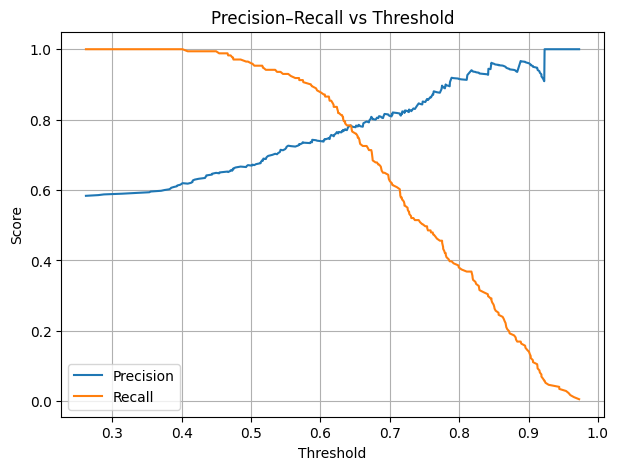

Precision/Recall intersect threshold: 0.644


In [7]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)

plt.figure(figsize=(7,5))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision–Recall vs Threshold")
plt.grid(True)
plt.show()

# Find threshold where they intersect
diff = np.abs(precisions[:-1] - recalls[:-1])
th_intersect = thresholds[np.argmin(diff)]
print("Precision/Recall intersect threshold:", round(th_intersect, 3))

### Question 4: F1 score

Max F1 threshold: 0.554
Max F1 value: 0.815


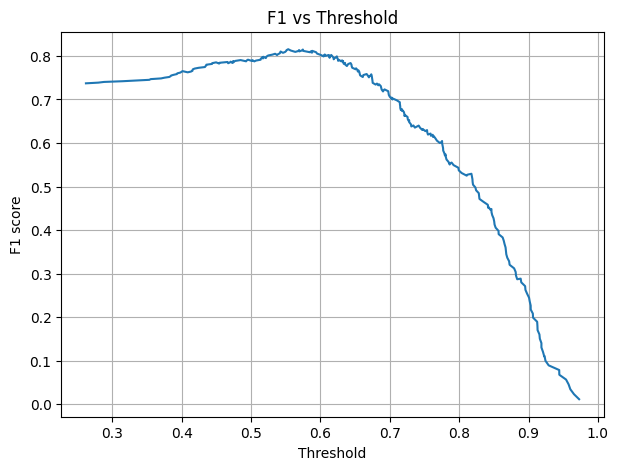

In [8]:
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
best_idx = np.argmax(f1_scores)
print("Max F1 threshold:", round(thresholds[best_idx], 3))
print("Max F1 value:", round(f1_scores[best_idx], 3))

plt.figure(figsize=(7,5))
plt.plot(thresholds, f1_scores, label="F1")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.title("F1 vs Threshold")
plt.grid(True)
plt.show()

### Question 5: 5-Fold Cross-Validation

In [9]:
!pip install tqdm
from tqdm import tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:
from tqdm import tqdm

kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in tqdm(kf.split(df_full_train)):
    df_train_kf = df_full_train.iloc[train_idx]
    df_val_kf = df_full_train.iloc[val_idx]

    y_train_kf = df_train_kf.converted.values
    y_val_kf = df_val_kf.converted.values

    train_dicts = df_train_kf.drop('converted', axis=1).to_dict(orient='records')
    val_dicts = df_val_kf.drop('converted', axis=1).to_dict(orient='records')

    X_train_kf = dv.fit_transform(train_dicts)
    X_val_kf = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_kf, y_train_kf)
    y_pred_kf = model.predict_proba(X_val_kf)[:, 1]
    auc = roc_auc_score(y_val_kf, y_pred_kf)
    scores.append(auc)

print("\nFold AUCs:", [round(s, 3) for s in scores])
print("Mean:", round(np.mean(scores), 3), "Std:", round(np.std(scores), 3))

5it [00:00, 42.72it/s]


Fold AUCs: [0.806, 0.871, 0.775, 0.802, 0.856]
Mean: 0.822 Std: 0.036


### Question 6: Hyperparameter tuning

In [11]:
for C in [0.000001, 0.001, 1]:
    scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        df_train_kf = df_full_train.iloc[train_idx]
        df_val_kf = df_full_train.iloc[val_idx]

        y_train_kf = df_train_kf.converted.values
        y_val_kf = df_val_kf.converted.values

        train_dicts = df_train_kf.drop('converted', axis=1).to_dict(orient='records')
        val_dicts = df_val_kf.drop('converted', axis=1).to_dict(orient='records')

        X_train_kf = dv.fit_transform(train_dicts)
        X_val_kf = dv.transform(val_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_kf, y_train_kf)
        y_pred_kf = model.predict_proba(X_val_kf)[:, 1]
        auc = roc_auc_score(y_val_kf, y_pred_kf)
        scores.append(auc)

    print(f"\nC={C}: mean={np.mean(scores):.3f}, std={np.std(scores):.3f}")


C=1e-06: mean=0.560, std=0.024

C=0.001: mean=0.867, std=0.029

C=1: mean=0.822, std=0.036
